In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lefs_cython.simple import LEFSimulator, constants
import lefs_cython
lefs_cython.LEFSimulator = LEFSimulator
import networkx as nx
import multiprocessing
import cProfile

colors = [
    'red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 
    'magenta', 'yellow', 'black', 'lime', 'teal', 'navy'
]

In [13]:
import networkx as nx

def shortest_path_with_shortcuts(shortcuts, start, end, processivity):
    G = nx.Graph()
    
    # Collect all unique points including start and end
    points = set()
    points.add(start)
    points.add(end)
    adjusted_shortcuts = []
    for shortcut in shortcuts:
        if (shortcut[1]<start - 1.5*processivity) or (shortcut[0]>end + 1.5*processivity): 
            pass
        else:
            adjusted_shortcuts.append(shortcut)
            points.update(shortcut)

    shortcuts = adjusted_shortcuts
    # Convert the set to a sorted list
    points = sorted(points)
    print(points)
    # Create a mapping from points to indices
    point_index = {point: idx for idx, point in enumerate(points)}
    
    # Add edges for direct distances between consecutive points
    for i in range(len(points) - 1):
        distance = abs(points[i] - points[i + 1])
        G.add_edge(point_index[points[i]], point_index[points[i + 1]], weight=distance)
    print(G.edges)  
    # Add shortcut edges using precomputed indices
    for xi, yi in shortcuts:
        G.add_edge(point_index[xi], point_index[yi], weight=0)
    
    # Find shortest path using Dijkstra's algorithm
    index_start = point_index[start]
    index_end = point_index[end]
    length, path = nx.single_source_dijkstra(G, index_start, index_end)
    
    # Return the shortest distance and the path taken
    # To return the actual points in the path, uncomment the following line:
    # return length, [points[node] for node in path]
    return length, len(path)

# Example usage:
shortcuts = [(1, 5), (2, 6), (90, 120), (140, 145), (145, 147), (147, 149), (149, 150), (150, 155)]
start = 100
end = 150
result = shortest_path_with_shortcuts(shortcuts, start, end, processivity=1)
print(result)

[90, 100, 120, 140, 145, 147, 149, 150, 155]
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)]
(30, 8)


In [90]:
8*4*3*20/60

32.0

In [5]:
def plot_LEFs(position):
    time = np.arange(LEF_steps)/60
    for k in range(N_LEFS):
        plt.plot(time, position[:,k,:], color = colors[k%len(colors)])
    return None

def compute_average_loop_size(position):
    return np.diff(position, axis = -1).mean().mean()

def compute_fpt(positions, target_size):
    fpts = []
    for _ in range(5000):
        t = np.random.randint(1000, len(positions))
        positions_conditionned = positions[t:]
        if np.argmax(positions_conditionned < target_size).sum() == 0: # if the target is never reached pass
            pass
        else:
            fpts.append(np.argmax(positions_conditionned < target_size))

    
    if len(fpts) == 0:
        mean_fpts =  len(positions)
    else:
        mean_fpts = np.mean(fpts)
    return mean_fpts, np.array(fpts)


def run_sim(N, N_LEFS, LEF_steps, processivity):

    load_array = 1 * np.ones((N, 5))
    unload_array = np.ones((N, 5))/(0.5*processivity)  
    capture_array = np.zeros((N, 2))  # no CTCF
    release_array = np.zeros(N)
    pause_array = np.zeros(N)  # no pausing
    
    positions = np.zeros((LEF_steps, N_LEFS, 2))
    LEF = LEFSimulator(N_LEFS, N, load_array, unload_array, capture_array, release_array, pause_array, skip_load=False)
    for k in range(LEF_steps):
        LEF.steps(k,k+1)
        positions[k,:,:] = LEF.get_LEFs()
    return np.array(positions)

def get_shortest_paths(LEF_positions, pos, sep, processivity):
    shortest = np.zeros(LEF_positions.shape[0])
    path = np.zeros(LEF_positions.shape[0])
    for k in range(LEF_positions.shape[0]):
        shortest[k], path[k] = shortest_path_with_shortcuts(LEF_positions[k,:,:], pos, pos + sep, processivity)
    return np.array(shortest), np.array(path)



719.4042553191489
11.990070921985815


array([ 754, 1340,  294, ...,  583,   25,  442])

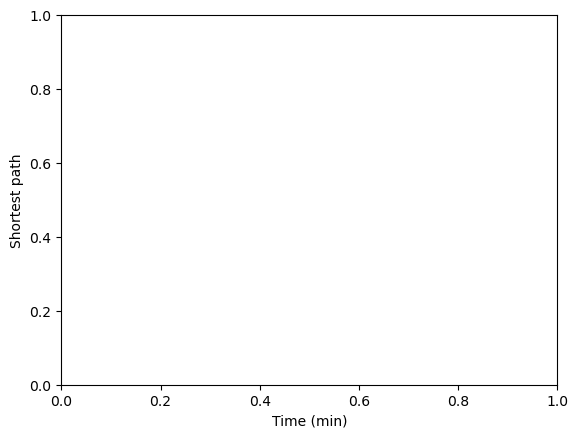

In [92]:
N = 10000
LEF_steps = 100000
processivities = np.linspace(300, 500, 5)
N_LEFSs = [100]
separation = [363]
target_sizes = [30]
replicate_positions = np.arange(1000, N - 1000, 5000)

LEF_steps = 1000000
N_LEFS = 100
N = 10000
v_2legs = 1
dt = 1
processivity = 300
separation = 500
pos = 750
position = run_sim(N, N_LEFS, LEF_steps, processivity)
shortest, path = get_shortest_paths(position, pos, separation, processivity)
# plot_LEFs(position)
# plt.axhline(y=pos, color='r', linestyle='--')
# plt.axhline(y=pos + separation, color='r', linestyle='--')   
# plt.show()
time = np.linspace(0, LEF_steps/v_2legs, LEF_steps)
# plt.plot(time, shortest)
plt.xlabel('Time (min)')
plt.ylabel('Shortest path')
plt.ylim(0)
# # plt.show()

# print('effectiv separation', shortest.mean())
# print('d = ', N/N_LEFS)
# print('lambda = ', compute_average_loop_size(position))
# print('lambda theoric = ', processivity)
# print('FPT = ', compute_fpt(shortest, target_size=20)[0]/60)

target_size = 30
fpt, fpts = compute_fpt(shortest, target_size=target_size)
print(fpt)
plt.axhline(y=target_size, color='r', linestyle='--')
fpts = np.array(fpts)
# print(shortest_conditionned < target_size)
print(fpts.mean()/60)
np.array(fpts)

# plt.hist(fpts, bins = 50)


In [95]:
((8*4*3*20)*1.5)/32

90.0

In [ ]:
8*4*3*20

In [86]:
import numpy as np
import multiprocessing as mp

# Function to process each combination of parameters
def process_combination(args):
    l, k, i, j, N = args
    pos = replicate_positions[l]
    sep = separation[k]
    N_LEFS = N_LEFSs[i]
    processivity = processivities[j]
    
    positions = run_sim(N, N_LEFS, LEF_steps, processivity) 

    shortest, path = get_shortest_paths(positions, pos, sep, processivity)

    shortest_mean = shortest.mean()

    number_of_loops = path.mean()

    average_loop_size = compute_average_loop_size(positions)

    fpt = np.zeros(len(target_sizes))
    for t, target_size in enumerate(target_sizes):
        fpt[t] = compute_fpt(shortest, target_size = target_size)[0]
    if (l+k+i+j) % 10 == 0:
        print(f'Completed {l+k+i+j} out of {len(replicate_positions)*len(separation)*len(N_LEFSs)*len(processivities)} tasks.')

    
    return l, k, i, j, shortest_mean, fpt, average_loop_size, number_of_loops

# Given values
N = 10000
LEF_steps = 1000000
processivities = np.linspace(50, 500, 20)
N_LEFSs = np.arange(10, 100, 10)
separation = [363, 473, 542]
target_sizes = [10, 20, 30, 50]
replicate_positions = np.arange(1000, N - 1000, 500)


N = 10000
LEF_steps = 100000
# processivities = np.linspace(10, 500, 20)
processivities = [500]
N_LEFSs = [30]
# separation = np.linspace(50, 1000, 20)
separation = [500]
target_sizes = [100]
replicate_positions = np.arange(1000, N - 1000, 5000)

# Prepare arguments for parallel processing
tasks = []

for l, pos in enumerate(replicate_positions):
    for k, sep in enumerate(separation):
        for i, N_LEFS in enumerate(N_LEFSs):
            for j, processivity in enumerate(processivities): 
                tasks.append((l, k, i, j, N))

# Execute tasks in parallel using multiprocessing
with mp.Pool(mp.cpu_count()) as pool:
    results = pool.map(process_combination, tasks)


shortests = np.zeros((len(replicate_positions), len(separation), len(N_LEFSs), len(processivities)))
fpts = np.zeros((len(target_sizes), len(replicate_positions), len(separation), len(N_LEFSs), len(processivities)))
average_loop_sizes = np.zeros((len(replicate_positions), len(separation), len(N_LEFSs), len(processivities)))
number_of_loops = np.zeros((len(replicate_positions), len(separation), len(N_LEFSs), len(processivities)))
loop_cooperations = np.zeros((len(replicate_positions), len(separation), len(N_LEFSs), len(processivities)))
# Store the results

for result in results:
    l, k, i, j, shortest_mean, fpt, average_loop_size, loop_cooperation = result
    shortests[l, k, i, j] = shortest_mean
    fpts[:, l, k, i, j] = fpt
    average_loop_sizes[l, k, i, j] = average_loop_size
    loop_cooperations[l, k, i, j] = loop_cooperation
    # print(N_LEFSs[i], processivities[j], shortests[k, i, j])

results_dic = {'shortests': shortests,
            'fpts': fpts,
            'N_LEFSs': N_LEFSs,
            'processivities': processivities,
            'separation': separation,
            'target_sizes': target_sizes,
            'average_loop_size' : average_loop_sizes,
            'number_of_loops' : number_of_loops
                }

# At this point, shortests and fpts arrays are populated with the desired values


Completed 0 out of 2 tasks.


result shape -> target, separation, Nlefs, procesivity, 

In [85]:
number_of_loops

array([[[[0.]]],


       [[[0.]]]])

In [56]:
plt.plot(processivities[3:], fpts[2,:,0,0,:].mean(axis = 0)[:]/60, '.')
# plt.ylim(0, 500)
plt.plot(processivities[3:], average_loop_sizes[:,0,0,:].mean(axis = 0)[:], '.')

IndexError: index 2 is out of bounds for axis 0 with size 1

In [147]:
import os 
results_dic = {'shortests': shortests,
            'fpts': fpts,
            'N_LEFSs': N_LEFSs,
            'processivities': processivities,
            'separation': separation,
            'target_sizes': target_sizes,
            'average_loop_size' : average_loop_sizes
                }
os.makedirs('./data/1D_fpt/28-06/', exist_ok=True)
np.save('./data/1D_fpt/28-06/results.npy', results_dic, allow_pickle=True)
np.save('./data/1D_fpt/28-06/replicate_positions.npy', replicate_positions, allow_pickle=True)
np.save('./data/1D_fpt/28-06/processivities.npy', processivities, allow_pickle=True)
np.save('./data/1D_fpt/28-06/N_LEFSs.npy', N_LEFSs, allow_pickle=True)
np.save('./data/1D_fpt/28-06/separation.npy', separation, allow_pickle=True)
np.save('./data/1D_fpt/28-06/target_sizes.npy', target_sizes, allow_pickle=True)
np.save('./data/1D_fpt/28-06/average_loop_size.npy', average_loop_sizes, allow_pickle=True)
np.save('./data/1D_fpt/28-06/shortests.npy', shortests, allow_pickle=True)
np.save('./data/1D_fpt/28-06/fpts.npy', fpts, allow_pickle=True)


/tmp/ipykernel_294312/2147103469.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


Text(0, 0.5, 'loop size/lambda')

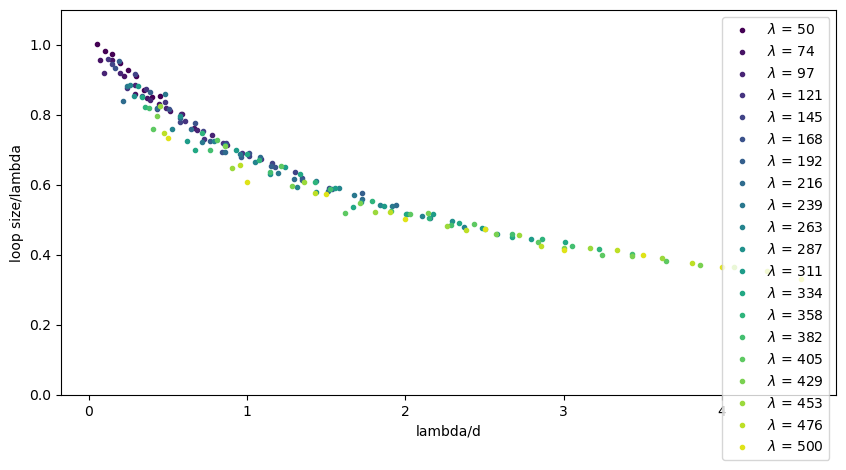

In [102]:
cmap = plt.cm.get_cmap('viridis')
plt.figure(figsize=(10, 5))
for k, processivity in enumerate(processivities):
    color = cmap(float(k) / len(processivities))
    x = processivity/(N/N_LEFSs)
    y = average_loop_sizes[0,0,:,k]/processivity
    plt.plot(x, y , '.', color = color, label = fr'$\lambda$ = {round(processivity)}')
plt.legend()
plt.ylim(0, 1.1)
plt.xlabel('lambda/d')
plt.ylabel('loop size/lambda')

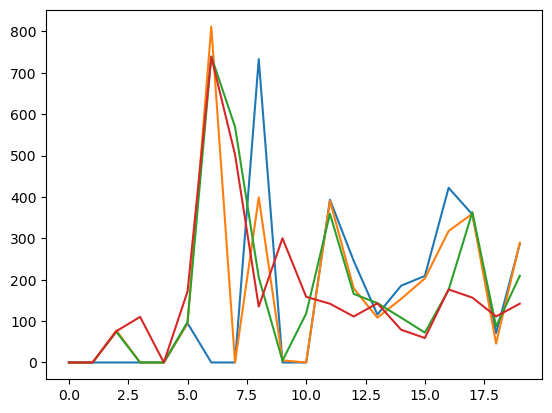

In [105]:
plt.plot(fpts[2,0,:])

In [88]:
taus = np.array([57, 70, 94])

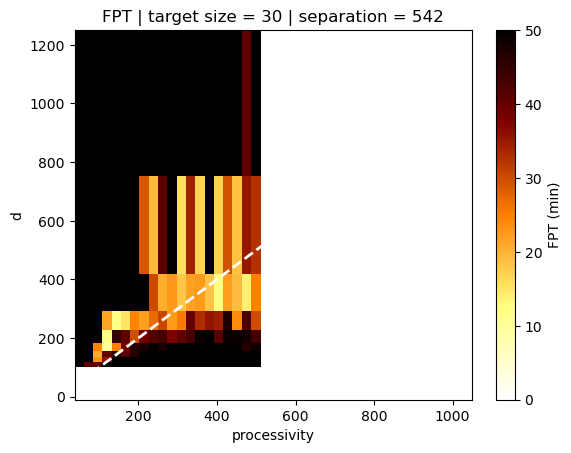

In [106]:
N_LEFS = np.load('./data/N_LEFSs.npy')
fpts = np.load('./data/fpts.npy')
processivities = np.load('./data/processivities.npy')
target_sizes = np.load('./data/target_sizes.npy')
d = N/N_LEFSs
y = d
x = processivities 
t = 2
k = 2

Z = np.sqrt(((fpts[:,:,:,t] - taus[:, None, None])**2).mean(axis = 0))

fig, ax = plt.subplots()
im = ax.pcolor(x, y, Z, cmap='afmhot_r', vmin = 0, vmax = 50)
plt.colorbar(im, label='FPT (min)')
plt.xlabel('processivity')
plt.ylabel('d')
plt.title(f'FPT | target size = {target_sizes[t]} | separation = {separation[k]}')
plt.plot(np.linspace(min(processivities), max(y)), np.linspace(min(processivities), max(y)), color = 'white', linestyle = '--', linewidth = 2, label  = r'$\lambda = d$')
# plt.ylim([100, 400])
# plt.xlim(0,500)


In [68]:
np.sqrt(((fpts[:,:,:,t] - taus[:, None, None])**2).mean(axis = 0))

array([[ 75.24404738,  75.24404738, 333.9991008 , 208.15980593,
        276.53360857, 125.6131905 , 478.9340055 , 232.78399878,
        198.40219703, 140.79945183, 304.38280856, 260.13020487,
        112.8078945 , 135.458329  , 205.29202574, 232.43505758,
        131.98315373, 169.20315682, 212.42839148, 206.03572751],
       [ 75.24404738, 316.78173198, 448.2619068 , 170.95813547,
         76.32631186, 199.29256569, 217.81332362, 116.77732001,
         53.26570682, 137.09861822,  78.682386  ,  16.65746558,
         89.75832682,  64.20522348, 156.36112568, 110.14889633,
         69.49766259,  22.01022873, 111.25459374,  55.40486409],
       [182.61099594, 153.29631798, 283.34140509, 146.15323743,
        168.20788181, 157.05657681, 116.63204625,  36.0071411 ,
         91.49777159,  47.83918961,  16.97027412,  27.10004617,
         16.63560549,  82.60087502,  20.71673988,  31.74608742,
         19.52828744,  50.25134504,  22.31040055,  34.92816971],
       [ 86.33544811, 429.75725846, 1

In [67]:
((fpts[:,:,:,t] - taus[:, None, None])**2).shape

(3, 9, 20)

In [44]:
fpts.shape

(3, 9, 20, 4)

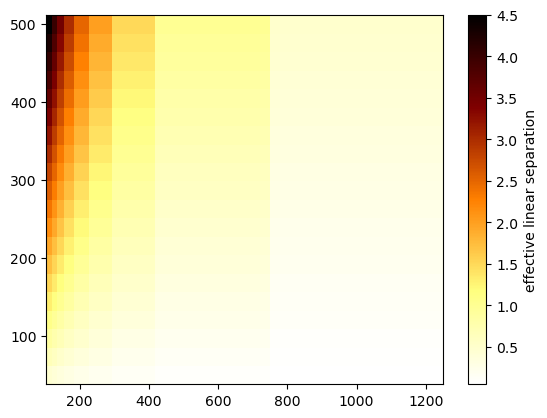

In [12]:
x =  N/np.arange(0, 100, 10)[1:]
y = processivities = np.linspace(50, 500, 20)

X, Y = np.meshgrid(x, y)
Z = Y / X

fig, ax = plt.subplots()
im = ax.pcolor(x, y, Z, cmap='afmhot_r')
plt.colorbar(im, label='effective linear separation')

(array([1.350e+03, 1.172e+03, 9.970e+02, 8.900e+02, 7.540e+02, 6.820e+02,
        6.100e+02, 4.900e+02, 4.020e+02, 3.420e+02, 3.160e+02, 2.680e+02,
        1.880e+02, 1.930e+02, 1.780e+02, 1.460e+02, 1.330e+02, 1.210e+02,
        1.070e+02, 9.400e+01, 7.400e+01, 8.300e+01, 5.500e+01, 5.700e+01,
        4.800e+01, 3.700e+01, 3.100e+01, 1.400e+01, 2.100e+01, 9.000e+00,
        1.400e+01, 4.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 9.000e+00,
        2.000e+00, 4.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 5.000e+00,
        4.000e+00, 3.000e+00, 6.000e+00, 2.000e+00, 5.000e+00, 3.000e+00,
        1.000e+00, 3.000e+00]),
 array([  0.        ,   7.57433333,  15.14866667,  22.723     ,
         30.29733333,  37.87166667,  45.446     ,  53.02033333,
         60.59466667,  68.169     ,  75.74333333,  83.31766667,
         90.892     ,  98.46633333, 106.04066667, 113.615     ,
        121.18933333, 128.76366667, 136.338     , 143.91233333,
        151.48666667, 159.061     , 166.63533333, 174.20

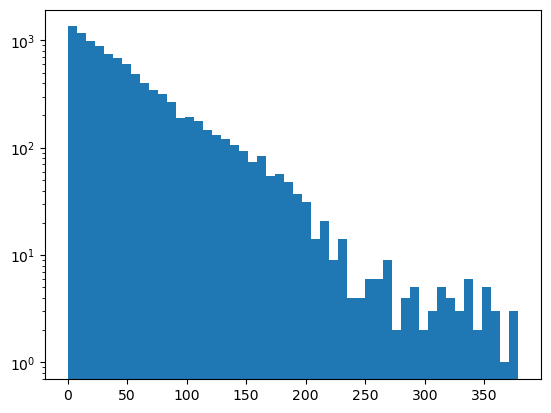

In [280]:
plt.semilogy()
plt.hist((compute_fpt(shortest, target_size=target_size)[1]/60), bins=50)

260.157335
lambda =  152.51480366666667
d =  333.3333333333333
lambda theoric =  200


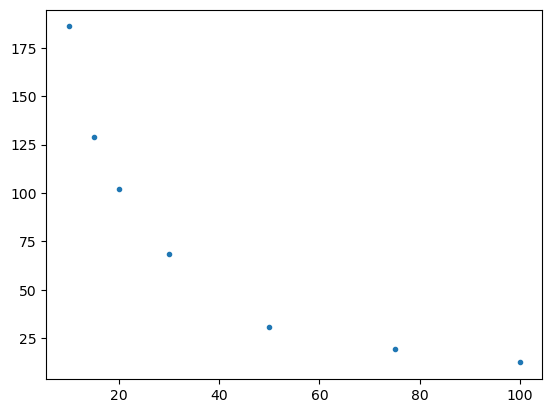

In [ ]:
LEF_steps = 1000000
N_LEFS = 3
N = 1000
processivity = 200
start = 300
end = 660
position, shortest = run_sim(N, N_LEFS, LEF_steps, processivity, start, end)
# plot_LEFs(position)
# plt.axhline(y=start, color='r', linestyle='--')
# plt.axhline(y=end, color='r', linestyle='--')   
# plt.show()
# time = np.arange(position.shape[0])/60
# plt.plot(time, shortest)
# plt.show()

print(shortest.mean())
print('lambda = ', compute_average_loop_size(position))
print('d = ', N/N_LEFS)
print('lambda theoric = ', processivity)


N_LEFSs = np.arange(1, 10, 1)
target_sizes = [10, 15, 20, 30, 50, 75, 100]
mean_fpts = []
for target_size in target_sizes:
    mean_fpts.append(compute_fpt(shortest, target_size=target_size)/60)[0]
mean_fpts = np.array(mean_fpts)
plt.plot(target_sizes, mean_fpts, '.')


# Shortest path search optimization

In [181]:
def shortest_path_with_shortcuts(shortcuts, start, end, exclusion):
    G = nx.Graph()
    
    # Collect all unique points including start and end
    points = set()
    points.add(start)
    points.add(end)
    adjusted_shortcuts = []
    if exclusion:
        for shortcut in shortcuts:
            if (shortcut[1]<start - 1.5*processivity) or (shortcut[0]>end + 1.5*processivity): 
                pass
            else:
                adjusted_shortcuts.append(shortcut)
                points.update(shortcut)
    else:
        for shortcut in shortcuts:
            adjusted_shortcuts.append(shortcut)
            points.update(shortcut)
    shortcuts = adjusted_shortcuts
    # Convert the set to a sorted list
    points = sorted(points)
    
    # Create a mapping from points to indices
    point_index = {point: idx for idx, point in enumerate(points)}
    
    # Add edges for direct distances between consecutive points
    for i in range(len(points) - 1):
        distance = abs(points[i] - points[i + 1])
        G.add_edge(point_index[points[i]], point_index[points[i + 1]], weight=distance)
    
    # Add shortcut edges using precomputed indices
    for xi, yi in shortcuts:
        G.add_edge(point_index[xi], point_index[yi], weight=0)
    
    # Find shortest path using Dijkstra's algorithm
    index_start = point_index[start]
    index_end = point_index[end]
    length, path = nx.single_source_dijkstra(G, index_start, index_end)
    
    # Return the shortest distance and the path taken
    # To return the actual points in the path, uncomment the following line:
    # return length, [points[node] for node in path]
    return length



def run_sim(N, N_LEFS, LEF_steps, processivity, start, end):

    steps_per_LEF_step = int(5200/2)
    load_array = 1 * np.ones((N, 5))
    unload_array = np.ones((N, 5))/(0.5*processivity)
    capture_array = np.zeros((N, 2))  # no CTCF
    release_array = np.zeros(N)
    pause_array = np.zeros(N)  # no pausing

    shortest = []
    positions = []
    LEF = LEFSimulator(N_LEFS, N, load_array, unload_array, capture_array, release_array, pause_array, skip_load=False)
    for k in range(LEF_steps):
        LEF.steps(k,k+1)
        positions.append(LEF.get_LEFs())
        shortest.append(shortest_path_with_shortcuts(LEF.get_LEFs(), start, end))
    return np.array(positions), np.array(shortest)

In [186]:
import time

N=10000
N_LEFS = 100
LEF_steps = 100000
processivity = 500
steps_per_LEF_step = int(5200/2)
load_array = 1 * np.ones((N, 5))
unload_array = np.ones((N, 5))/(0.5*processivity)  
capture_array = np.zeros((N, 2))  # no CTCF
release_array = np.zeros(N)
pause_array = np.zeros(N)  # no pausing

start = 5000
end = 5000 + 540
LEF = LEFSimulator(N_LEFS, N, load_array, unload_array, capture_array, release_array, pause_array, skip_load=False)
# positions = []
counter= 0
start_time = time.time()
for k in range(100000):
    # LEF.steps(k,k+1)
    # positions.append(LEF.get_LEFs())
    shortest_path_with_shortcuts(positions[k], start, end, exclusion=True)
    # if not shortest_path_with_shortcuts(positions[k], start, end, exclusion=True) == shortest_path_with_shortcuts(positions[k], start, end, exclusion=False):
    #     counter += 1
# print(counter)

# positions = np.array(positions)
end_time = time.time()
print(f"With exclusion The function took {end_time - start_time} seconds to run.")

start_time = time.time()
for k in range(100000):
    # LEF.steps(k,k+1)
    # positions.append(LEF.get_LEFs())
    shortest_path_with_shortcuts(positions[k], start, end, exclusion=False)
    # if not shortest_path_with_shortcuts(positions[k], start, end, exclusion=True) == shortest_path_with_shortcuts(positions[k], start, end, exclusion=False):
    #     counter += 1
# print(counter)

# positions = np.array(positions)
end_time = time.time()
print(f"without The function took {end_time - start_time} seconds to run.")

With exclusion The function took 3.324995994567871 seconds to run.
without The function took 4.372920513153076 seconds to run.


235.1488
175.8141


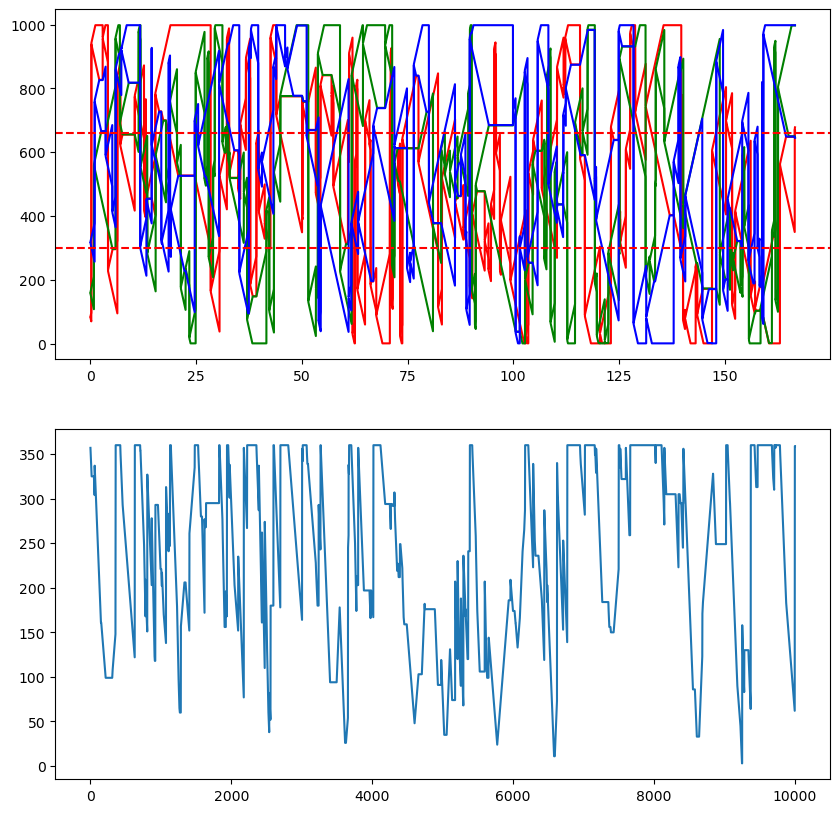

In [198]:

LEF_steps = 10000
N_LEFS = 3
N = 1000
processivity = 200
start = 300
end = 660
plt.figure(figsize=(10,10))
position, shortest = run_sim(N, N_LEFS, LEF_steps, processivity, start, end)
plt.subplot(2,1,1)
plot_LEFs(position)
plt.axhline(y=start, color='r', linestyle='--')
plt.axhline(y=end, color='r', linestyle='--')   

plt.subplot(2,1,2)
plt.plot(shortest)
print(shortest.mean())
print(compute_average_loop_size(position))

# CRAP

def shortest_path_with_shortcuts_old(shortcuts, start, end):
    G = nx.Graph()
    
    # Collect all unique points including start and end
    points = set()
    points.add(start)
    points.add(end)
    
    for shortcut in shortcuts:
        points.update(shortcut)
    
    # Convert the set to a sorted list
    points = sorted(points)
    
    # Add nodes
    for i, point in enumerate(points):
        G.add_node(i, pos=(point, 0))
    
    # Add edges for direct distances between consecutive points
    for i in range(len(points) - 1):
        distance = abs(points[i] - points[i + 1])
        G.add_edge(i, i + 1, weight=distance)
    
    # Add shortcut edges
    for shortcut in shortcuts:
        xi, yi = shortcut
        index_x = points.index(xi)
        index_y = points.index(yi)
        G.add_edge(index_x, index_y, weight=0)
    
    # Find shortest path using Dijkstra's algorithm
    index_start = points.index(start)
    index_end = points.index(end)
    length, path = nx.single_source_dijkstra(G, index_start, index_end)
    
    # Return the shortest distance and the path taken
    return length#, [points[node] for node in path]
